# Lesson 19: Regression demonstration

This notebook demonstrates key concepts and tools for training supervised regression models.

1. **What is regression**
    - Regression problems
    - Model training

2. **Regression metrics**
    - Residuals: RSS, MSE, RMSE and MAE
    - R-squared

3. **Evaluating regression model performance**
    - Train-test split
    - Overfitting

4. **Dealing with overfitting**
    - Ridge (L2) penalty
    - Lasso (L1) penalty

5. **Optimizing regression models**
    - Hyperparameter tuning
    - Grid search/Randomized search

6. **Scikit-learn pipelines example**

## Notebook set up
### Import libraries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

## 1. What is regression?

A regression model predicts the value of a continuous output variable (label) from one or more input variables (features).

### 1.1. Regression problem: circumference of a circle

In [2]:
df = pd.read_csv('diameter_circumference.csv')
df

,diameter,circumference
0,3.0,9.056466
1,3.2,10.247696
2,3.6,11.015775
3,4.8,14.788864
4,6.1,19.385014
5,7.2,22.025133
6,8.7,27.192756
7,10.0,31.244334
8,11.3,35.256537
9,11.9,37.321937


In [3]:
def regression_model(diameters):
    circumferences = np.pi * diameters
    return circumferences

circumference_predictions = regression_model(df['diameter'])

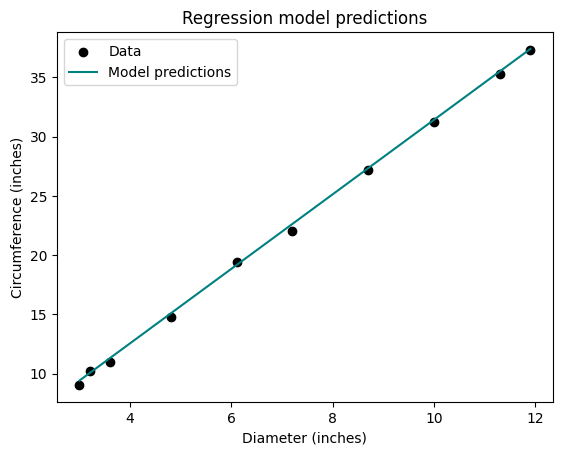

In [4]:
plt.title('Regression model predictions')
plt.scatter(df['diameter'], df['circumference'], color='black', label='Data')
plt.plot(df['diameter'], circumference_predictions, color='teal', label='Model predictions')
plt.xlabel('Diameter (inches)')
plt.ylabel('Circumference (inches)')
plt.legend()
plt.show()

### 1.2. Model training

In [5]:
from sklearn.linear_model import LinearRegression

# Create an instance of sklearn's LinearRegression() class
model = LinearRegression()

# Train the model
result = model.fit(df['diameter'].to_frame(), df['circumference'])

In [6]:
# Get predicted circumferences from diameters using the fitted model
predicted_circumference = model.predict(df['diameter'].to_frame())
print(f'Slope: {model.coef_[0]:.3f}')
print(predicted_circumference)

Slope: 3.141
[ 9.25330309  9.88145123 11.13774753 14.90663642 18.98959939 22.4444142
 27.15552532 31.23848828 35.32145125 37.20589569]


## 2. Regression metrics

### 2.1. Residuals

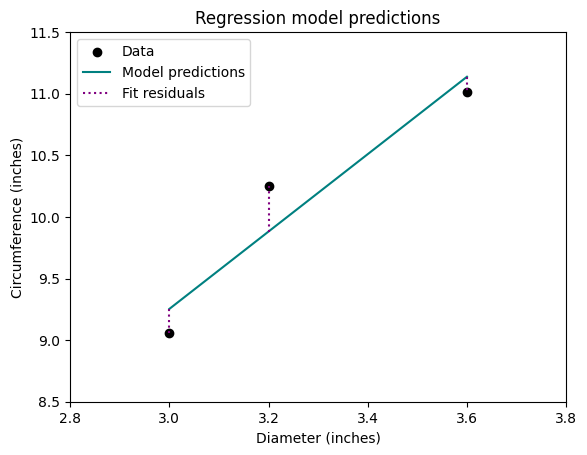

In [7]:
residuals = df['circumference'] - predicted_circumference

plt.title('Regression model predictions')
plt.scatter(df['diameter'][:3], df['circumference'][:3], color='black', label='Data')
plt.plot(df['diameter'][:3], predicted_circumference[:3], color='teal', label='Model predictions')

# Add vertical dotted lines for residuals
for i in range(3):
    plt.plot(
        [df['diameter'].iloc[i], df['diameter'].iloc[i]], 
        [predicted_circumference[i], df['circumference'].iloc[i]], 
        linestyle=':', color='purple', label='Fit residuals' if i == 0 else None
    )

plt.xlim(2.8, 3.8)
plt.ylim(8.5, 11.5)
plt.xlabel('Diameter (inches)')
plt.ylabel('Circumference (inches)')
plt.legend()
plt.show()

In [8]:
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error
)

# Calculate metrics using sklearn
MSE = mean_squared_error(df['circumference'], predicted_circumference)
RMSE = root_mean_squared_error(df['circumference'], predicted_circumference)
MAE = mean_absolute_error(df['circumference'], predicted_circumference)

# RSS is not directly available in sklearn, but can be calculated from MSE
n = len(df)
RSS = MSE * n

print(f'RSS:  {RSS:.4f} inches²')
print(f'MSE:  {MSE:.4f} inches²')
print(f'RMSE: {RMSE:.4f} inches')
print(f'MAE:  {MAE:.4f} inches')

RSS:  0.5529 inches²
MSE:  0.0553 inches²
RMSE: 0.2351 inches
MAE:  0.1842 inches


### 2.2. R-squared

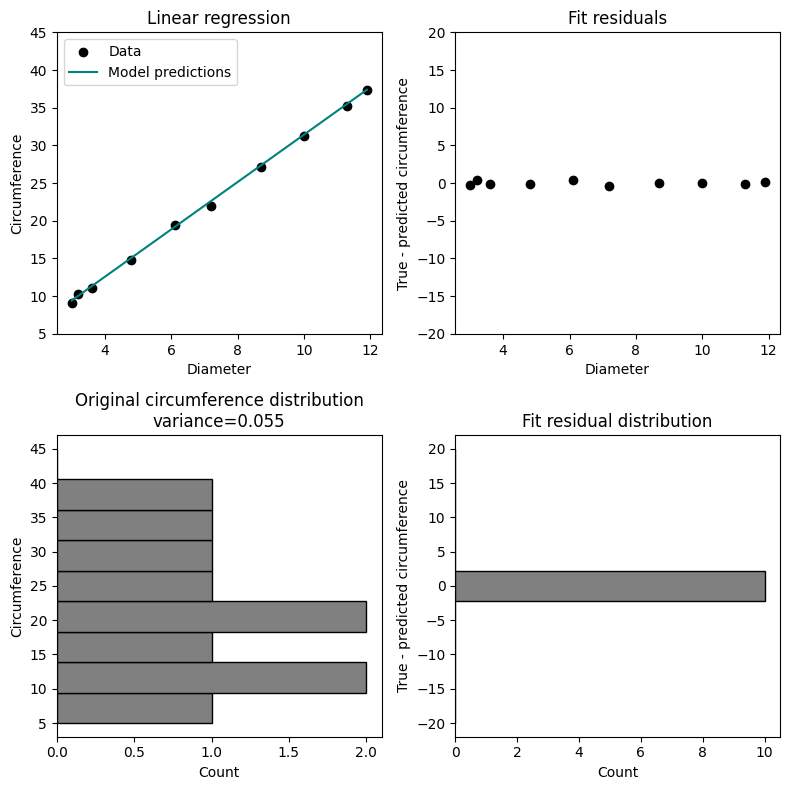

In [9]:
circumference_variance = np.var(df['circumference'])
residual_variance = np.var(residuals)

fig, axs = plt.subplots(2,2, figsize=(8,8))
axs = axs.flatten()

axs[0].set_title('Linear regression')
axs[0].scatter(df['diameter'], df['circumference'], color='black', label='Data')
axs[0].plot(df['diameter'], circumference_predictions, color='teal', label='Model predictions')
axs[0].set_ylim(5, 45)
axs[0].set_xlabel('Diameter')
axs[0].set_ylabel('Circumference')
axs[0].legend(loc='upper left')

axs[1].set_title('Fit residuals')
axs[1].scatter(df['diameter'], residuals, color='black')
axs[1].set_ylim(-20, 20)
axs[1].set_xlabel('Diameter')
axs[1].set_ylabel('True - predicted circumference')

bins = np.linspace(5, 45, 10)
axs[2].set_title(f'Original circumference distribution\nvariance={circumference_variance:.3f}')
axs[2].hist(df['circumference'], color='grey', edgecolor='black', bins = bins, orientation='horizontal')
axs[2].set_xlabel('Count')
axs[2].set_ylabel('Circumference')

bins = np.linspace(-20, 20, 10)
axs[2].set_title(f'Original circumference distribution\nvariance={residual_variance:.3f}')
axs[3].set_title('Fit residual distribution')
axs[3].hist(residuals, color='grey', edgecolor='black', bins=bins, orientation='horizontal')
axs[3].set_xlabel('Count')
axs[3].set_ylabel('True - predicted circumference')

fig.tight_layout()

In [10]:
variance_explained = 1 - (residual_variance / circumference_variance)
print(f'Fraction of variance explained: {variance_explained:.3f}')

Fraction of variance explained: 0.999


In [11]:
from sklearn.metrics import r2_score

sk_r2 = r2_score(df['circumference'], predicted_circumference)
print(f'Scikit-learn R-squared: {sk_r2:.3f}')

Scikit-learn R-squared: 0.999


## 3. Evaluating regression model performance

In [12]:
url = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/distance_to_water_preprocessed.csv'
df = pd.read_csv(url)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 465 entries, area to distance_to_water
dtypes: float64(465)
memory usage: 17.7 MB


### 3.1. Train-test split

In [13]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df)

print(f'Original dataframe shape: {df.shape}')
print(f'Training dataframe shape: {train_df.shape}')
print(f'Testing dataframe shape: {test_df.shape}')

Original dataframe shape: (5000, 465)
Training dataframe shape: (3750, 465)
Testing dataframe shape: (1250, 465)


In [45]:
# Fit linear model on training data
model = LinearRegression()

fit_result = model.fit(
    train_df.drop(columns='distance_to_water'),
    train_df['distance_to_water']
)

train_predictions = model.predict(
    train_df.drop(columns='distance_to_water')
)

train_rmse = root_mean_squared_error(train_df['distance_to_water'], train_predictions)
print(f'Training RMSE: {train_rmse:.1f}')
print(f'{train_predictions[0]} - {train_df['distance_to_water'][0]}')

Training RMSE: 92.2
111.98634284649674 - 95.88829326135324


In [46]:
# Used pre-fitted linear model to make predictions for test set features
test_predictions = model.predict(
    test_df.drop(columns='distance_to_water')
)

test_rmse = root_mean_squared_error(test_df['distance_to_water'], test_predictions)
print(f'Testing RMSE: {test_rmse:.1f}')

Testing RMSE: 109.4


### 3.2. Cross-validation

In [47]:
from sklearn.model_selection import cross_val_score

# Make a linear regression instance
model = LinearRegression()

# Run cross-validation scoring
cv_scores = cross_val_score(
    model,
    df.drop(columns='distance_to_water'),
    df['distance_to_water'],
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    cv=5
)

# Need to flip the sign - cross-validation used negative RMSE 
cv_scores = -cv_scores

# Get mean and standard deviation, construct 95% CI
rmse_mean = np.mean(cv_scores)
rmse_std = np.std(cv_scores)
moe_95 = 1.96 * rmse_std / np.sqrt(len(cv_scores))

print(f'Mean cross-validation RMSE: {rmse_mean:.1f} ± {moe_95:.1f}')
print(f'95% CI: ± {rmse_mean - moe_95:.1f} to {rmse_mean + moe_95:.1f}')
print(f'Test RMSE: {test_rmse:.1f}')

Mean cross-validation RMSE: 105.2 ± 3.7
95% CI: ± 101.5 to 108.9
Test RMSE: 109.4


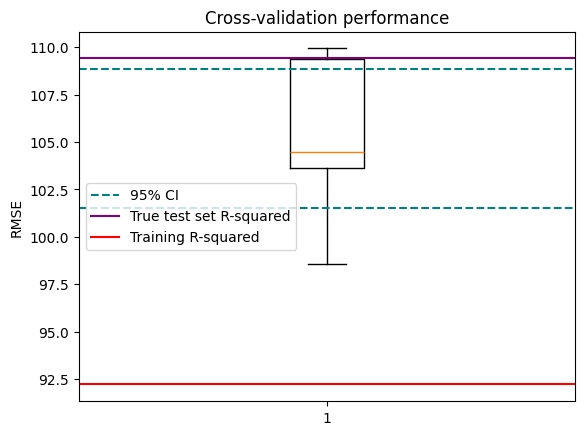

In [48]:
plt.title('Cross-validation performance')
plt.boxplot(cv_scores)
plt.axhline(rmse_mean - moe_95, linestyle='--', color='teal', label='95% CI')
plt.axhline(rmse_mean + moe_95, linestyle='--', color='teal')
plt.axhline(test_rmse, color='purple', label='True test set R-squared')
plt.axhline(train_rmse, color='red', label='Training R-squared')
plt.ylabel('RMSE')
plt.xlabel('')
plt.legend(loc='center left')
plt.show()

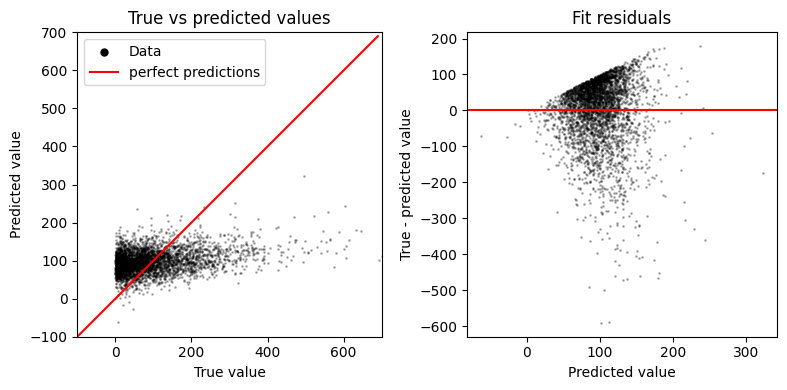

In [49]:
fig, axs = plt.subplots(1,2, figsize=(8,4))
axs = axs.flatten()

axs[0].set_title('True vs predicted values')
axs[0].scatter(
    train_df['distance_to_water'], train_predictions,
    s=1, alpha=0.25, color='black', label='Data'
)
axs[0].plot(
    list(range(-100, 700, 10)), list(range(-100, 700, 10)), 
    color='red', label='perfect predictions'
)
axs[0].set_xlabel('True value')
axs[0].set_ylabel('Predicted value')
axs[0].set_aspect('equal', adjustable='box')
axs[0].set_ylim(-100, 700)
axs[0].set_xlim(-100, 700)
leg = axs[0].legend(loc='upper left', markerscale=5)
leg.legend_handles[0].set_alpha(1)

axs[1].set_title('Fit residuals')
axs[1].scatter(
    train_predictions, train_predictions - train_df['distance_to_water'], 
    s=1, alpha=0.25, color='black'
)
axs[1].axhline(0, color='red', label='perfect predictions' )
axs[1].set_xlabel('Predicted value')
axs[1].set_ylabel('True - predicted value')

fig.tight_layout()

### 3.3. Over fitting

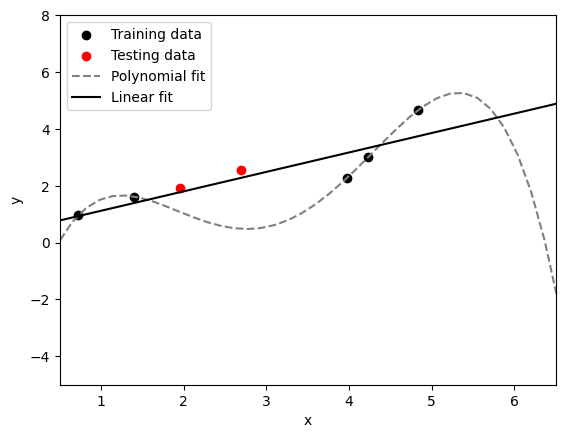

In [50]:
x_training=np.array([1,2,3,4,5]) + np.random.normal(-0.5,0.5,5)
y_training=np.array([1,2,3,4,5]) + np.random.normal(-0.5,0.5,5)

x_test=np.array([2.5,3.5]) + np.random.normal(-0.5,0.5,2)
y_test=np.array([2.5,3.5]) + np.random.normal(-0.5,0.5,2)

poly_fit=np.polyfit(x_training,y_training,4)
poly_model=np.poly1d(poly_fit)

x_range=np.linspace(0,8)
y_poly=poly_model(x_range)

linear_model=LinearRegression()
linear_model.fit(x_training.reshape(-1, 1), y_training)
y_linear=linear_model.predict(x_range.reshape(-1, 1))

plt.scatter(x_training,y_training, color='black', label='Training data')
plt.scatter(x_test,y_test, color='red', label='Testing data')
plt.plot(x_range, y_poly, linestyle='dashed', color='grey', label='Polynomial fit')
plt.plot(x_range, y_linear, color='black', label='Linear fit')
plt.xlim(0.5,6.5)
plt.ylim(-5,8)
plt.xlabel('x')
plt.ylabel('y')
plt.legend(loc='best')
plt.show()

## 4. Dealing with overfitting

Regularization adds penalty terms to prevent overfitting by shrinking coefficients.

### 4.2. Ridge regression (L2)

Penalizes model with an extra term: 'alpha' times the coefficients' sum-of-squares.
- Large coefficient -> large penalty
- Makes coefficients tend to be small but not zero


In [51]:
from sklearn.linear_model import Ridge

# Train Ridge regression with different alpha values
alphas = [0.01, 0.1, 1.0, 10.0, 100.0]
training_scores = []
testing_scores = []

for alpha in alphas:

    ridge_model = Ridge(alpha=alpha)

    ridge_model.fit(
        train_df.drop(columns='distance_to_water'),
        train_df['distance_to_water']
    )

    ridge_training_predictions = ridge_model.predict(
        train_df.drop(columns='distance_to_water')
    )

    ridge_testing_predictions = ridge_model.predict(
        test_df.drop(columns='distance_to_water')
    )

    training_scores.append(
        root_mean_squared_error(train_df['distance_to_water'], ridge_training_predictions)
    )

    testing_scores.append(
        root_mean_squared_error(test_df['distance_to_water'], ridge_testing_predictions)
    )

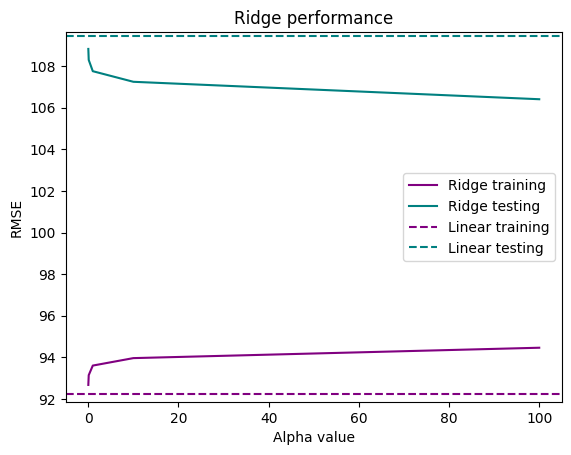

In [52]:
plt.title('Ridge performance')
plt.plot(alphas, training_scores, color='purple', label='Ridge training')
plt.plot(alphas, testing_scores, color='teal', label='Ridge testing')
plt.axhline(train_rmse, color='purple', linestyle='--', label='Linear training')
plt.axhline(test_rmse, color='teal', linestyle='--', label='Linear testing')
plt.xlabel('Alpha value')
plt.ylabel('RMSE')
plt.legend()
plt.show()

### 4.2. Lasso regression (L1)

Penalizes model with an extra term: 'alpha' times the sum of the absolute value of the coefficients.
- Larger coefficients -> larger penalty
- Will drive coefficients to zero (feature selection)

In [53]:
from sklearn.linear_model import Lasso

# Train Lasso regression with different alpha values
alphas = [0.025, 0.05, 0.1]

training_scores = []
testing_scores = []

for alpha in alphas:

    lasso_model = Lasso(alpha=alpha, max_iter=20000)

    lasso_model.fit(
        train_df.drop(columns='distance_to_water'),
        train_df['distance_to_water']
    )

    lasso_training_predictions = lasso_model.predict(
        train_df.drop(columns='distance_to_water')
    )

    lasso_testing_predictions = lasso_model.predict(
        test_df.drop(columns='distance_to_water')
    )

    training_scores.append(
        root_mean_squared_error(train_df['distance_to_water'], lasso_training_predictions)
    )

    testing_scores.append(
        root_mean_squared_error(test_df['distance_to_water'], lasso_testing_predictions)
    )

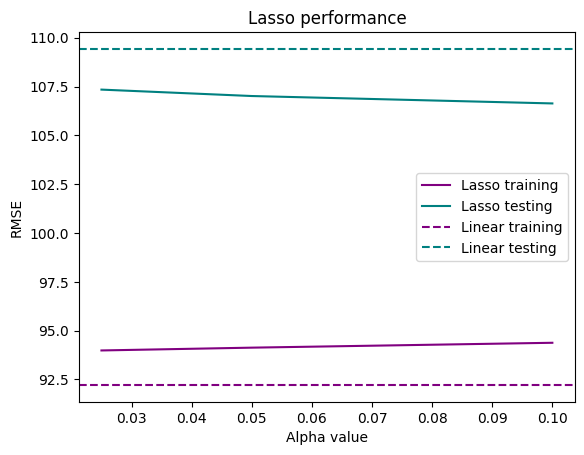

In [54]:
plt.title('Lasso performance')
plt.plot(alphas, training_scores, color='purple', label='Lasso training')
plt.plot(alphas, testing_scores, color='teal', label='Lasso testing')
plt.axhline(train_rmse, color='purple', linestyle='--', label='Linear training')
plt.axhline(test_rmse, color='teal', linestyle='--', label='Linear testing')
plt.xlabel('Alpha value')
plt.ylabel('RMSE')
plt.legend()
plt.show()

## 5. Optimizing regression models

Alpha is the first good example of a 'hyperparameter' we have encountered and there are many, many others. In general a hyperparameter is a value you can tune or a setting choice you can make that effects how the model learns from the data. The best values need to be determined empirically for the specific model and dataset.

In [ ]:
from scipy.stats import uniform
from sklearn.model_selection import RandomizedSearchCV

# Define parameter grid for Ridge regression
param_grid = {'alpha': uniform(loc=0.03, scale=0.04)}

# Create GridSearchCV object
grid_search = RandomizedSearchCV(
    Lasso(max_iter=20000),
    param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=16
)

# Fit on training data
grid_search.fit(
    train_df.drop(columns='distance_to_water'),
    train_df['distance_to_water']
)

print(f'Best alpha: {grid_search.beaxsst_params_["alpha"]:.3f}')
print(f'Best CV RMSE: {-grid_search.best_score_:.1f}')

/home/ksims/Classwork_ml/.venv/lib64/python3.12/site-packages/sklearn/linear_model/_coordinate_descent.py:695: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.348e+04, tolerance: 2.287e+03
  model = cd_fast.enet_coordinate_descent(


Best alpha: 0.067
Best CV RMSE: 100.9


In [56]:
# Evaluate best model on test set
lasso = Lasso(alpha=grid_search.best_params_["alpha"], max_iter=20000)

result = lasso.fit(
    train_df.drop(columns='distance_to_water'),
    train_df['distance_to_water']
)

train_predictions_lasso = lasso.predict(train_df.drop(columns='distance_to_water'))
train_rmse_lasso = root_mean_squared_error(train_df['distance_to_water'], train_predictions_lasso)
test_predictions_lasso = lasso.predict(test_df.drop(columns='distance_to_water'))
test_rmse_lasso = root_mean_squared_error(test_df['distance_to_water'], test_predictions_lasso)

print(f'Train RMSE (linear):  {train_rmse:.1f}')
print(f'Test RMSE (linear):   {test_rmse:.1f}')
print()
print(f'Train RMSE (lasso):   {train_rmse_lasso:.1f}')
print(f'Test RMSE (lasso):    {test_rmse_lasso:.1f}')

Train RMSE (linear):  92.2
Test RMSE (linear):   109.4

Train RMSE (lasso):   94.2
Test RMSE (lasso):    106.9


## 6. Scikit-learn pipelines

Pipelines combine preprocessing and modeling steps to prevent data leakage and simplify workflow.

In [57]:
# Load raw data again for pipeline demo
url = 'https://gperdrizet.github.io/FSA_devops/assets/data/unit3/distance_to_water.csv'
raw_df = pd.read_csv(url)

# Split before any preprocessing
train_df, test_df = train_test_split(raw_df)

In [58]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Define numeric and categorical columns
numeric_features = ['area','temperature', 'humidity', 'wind_speed','rainfall']
categorical_features = ['quality', 'region']

# Create preprocessing steps
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first', sparse_output=False))
])

# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('Numerical', numeric_transformer, numeric_features),
        ('Categorical', categorical_transformer, categorical_features)
    ]
)

# Create full pipeline with preprocessing and model
pipeline = Pipeline(steps=[
    ('Preprocessor', preprocessor),
    ('Model', Lasso(alpha=grid_search.best_params_["alpha"], max_iter=20000))
])

pipeline

,steps,"[('Preprocessor', ...), ('Model', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('Numerical', ...), ('Categorical', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


### 6.2. Train and evaluate pipeline

In [59]:
# Fit pipeline on training data
pipeline.fit(train_df.drop(columns='distance_to_water'), train_df['distance_to_water'])

# Make predictions on test set
predictions = pipeline.predict(test_df.drop(columns='distance_to_water'))

# Evaluate performance
pipeline_rmse = root_mean_squared_error(test_df['distance_to_water'], predictions)

print(f'Pipeline RMSE: {pipeline_rmse:.1f}')

Pipeline RMSE: 95.9
